In [47]:
from sim_core.engine import Engine
from sim_core.car import Car
from sim_core.autoTransmission import AutoTransmission
from sim_core.utils import ms_to_kph, example_torque_curve

engine = Engine(
    ratio_gears=[3.5, 2.8, 2.1, 1.7, 1.3, 1],
    ratio_differential=4,
    torque_output = example_torque_curve,
    max_rpm=10000,
    min_rpm=500,
    idle_rpm=2000
)

car = Car(
    mass=700,
    radius_wheel=0.3,
    engine=engine
)

auto_transmission = AutoTransmission(
    car.engine,
    8000,
    3000
)

# Stress
To estimate the tire degradation we need a way to model the stress applied on the tires. Here we create a way to calculate stress based on the forces applied on the tires, the temperature of the compound and the grip (or roughness) of the track.

In [48]:
def calculate_stress(longitudinal_force, lateral_force, vertical_force, temperature, surface_grip):
    # Constants for each force type
    k_longitudinal = 0.1
    k_lateral = 0.2
    k_vertical = 0.05

    # Temperature effect (assuming optimal_temperature is the ideal tire temperature)
    optimal_temperature = 90  # in Celsius, for example
    temperature_factor = 1 + (temperature - optimal_temperature)**2 * 0.001

    # Surface grip effect
    grip_factor = 1 + surface_grip  # assuming surface_grip is a value between 0 (low grip) and 1 (high grip)

    # Calculate stress from each force
    stress_longitudinal = k_longitudinal * longitudinal_force
    stress_lateral = k_lateral * lateral_force
    stress_vertical = k_vertical * vertical_force

    # Combine stresses
    total_stress = (stress_longitudinal + stress_lateral + stress_vertical) * temperature_factor * grip_factor

    return total_stress / 100

In [49]:
base_long_force = 2000
base_lat_force = 0
base_ver_force = 25000
base_temp = 90
base_grip = 0.8

Text(0.5, 1.0, 'Effect of longitudinal forces on stress')

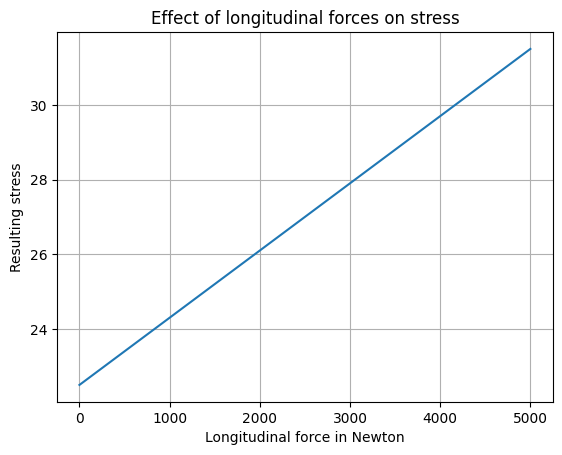

In [50]:
stress = []

for i in range(0, 5000):
    stress.append(calculate_stress(i, base_lat_force, base_ver_force, base_temp, base_grip))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(stress)
ax.grid()
ax.set_ylabel('Resulting stress')
ax.set_xlabel('Longitudinal force in Newton')
ax.set_title('Effect of longitudinal forces on stress')

Text(0.5, 1.0, 'Effect of lateral forces on stress')

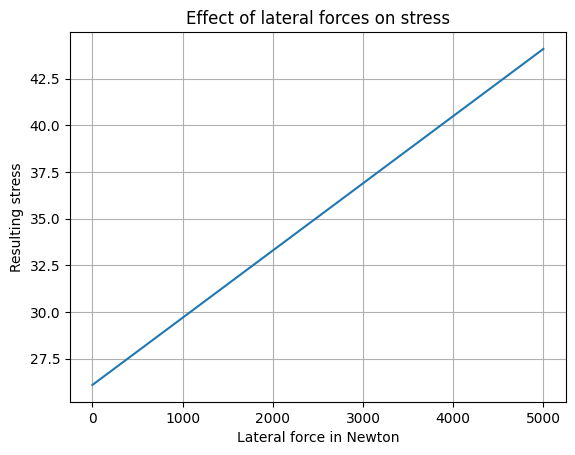

In [51]:
stress = []

for i in range(0, 5000):
    stress.append(calculate_stress(base_long_force, i, base_ver_force, base_temp, base_grip))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(stress)
ax.grid()
ax.set_ylabel('Resulting stress')
ax.set_xlabel('Lateral force in Newton')
ax.set_title('Effect of lateral forces on stress')

Text(0.5, 1.0, 'Effect of vertical forces on stress')

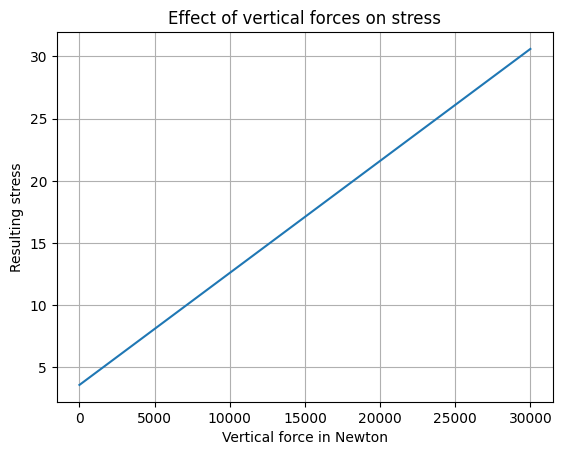

In [52]:
stress = []

for i in range(0, 30000):
    stress.append(calculate_stress(base_long_force, base_lat_force, i, base_temp, base_grip))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(stress)
ax.grid()
ax.set_ylabel('Resulting stress')
ax.set_xlabel('Vertical force in Newton')
ax.set_title('Effect of vertical forces on stress')

Text(0.5, 1.0, 'Effect of temperature on stress')

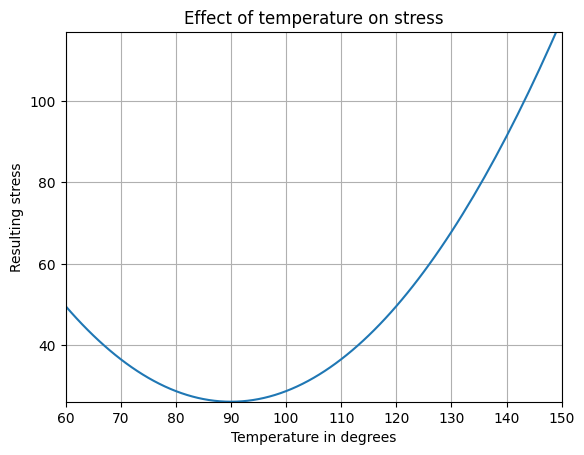

In [53]:
stress = []

for i in range(0, 150):
    stress.append(calculate_stress(base_long_force, base_lat_force, base_ver_force, i, base_grip))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(stress)
ax.grid()
ax.set_xlim([60, 150])
ax.set_ylim([min(stress[60:150]), max(stress[60:150])])
ax.set_ylabel('Resulting stress')
ax.set_xlabel('Temperature in degrees')
ax.set_title('Effect of temperature on stress')

Text(0.5, 1.0, 'Effect of track grip on stress')

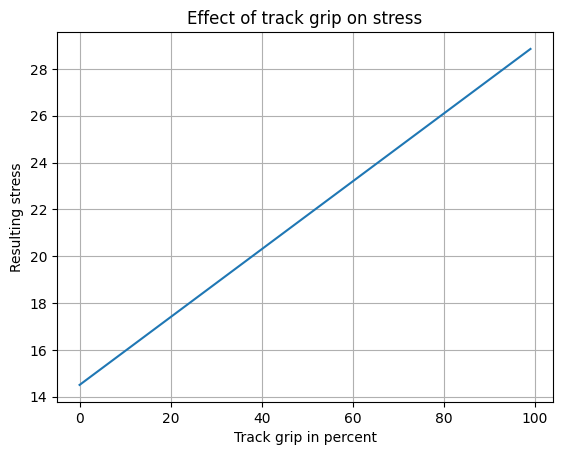

In [54]:
stress = []

for i in range(0, 100):
    stress.append(calculate_stress(base_long_force, base_lat_force, base_ver_force, base_temp, i/100))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(stress)
ax.grid()
ax.set_ylabel('Resulting stress')
ax.set_xlabel('Track grip in percent')
ax.set_title('Effect of track grip on stress')

In [55]:
class Compound:
    def __init__(self, name, base_grip, initial_degradation_rate, degradation_rate_change):
        self.name = name
        self.base_grip = base_grip
        self.initial_degradation_rate = initial_degradation_rate
        self.degradation_rate_change = degradation_rate_change


class Tire:
    def __init__(self, compound):
        self.compound = compound
        self.current_grip = compound.base_grip
        self.cumulative_stress = 0  # Cumulative stress the tire has experienced

    def get_grip(self):
        # Calculate the current grip based on cumulative stress and degradation rates from the compound
        degradation = (self.compound.initial_degradation_rate * self.cumulative_stress + 
                       0.5 * self.compound.degradation_rate_change * self.cumulative_stress**2)
        self.current_grip = max(self.compound.base_grip - degradation, 0)  # Ensure grip doesn't go negative
        return self.current_grip

    def apply_stress(self, stress):
        # Increase the cumulative stress based on the stress applied during a simulation step
        self.cumulative_stress += stress / 100

    def reset(self):
        # Reset the tire to its initial state (useful for simulations with new tires)
        self.current_grip = self.compound.base_grip
        self.cumulative_stress = 0

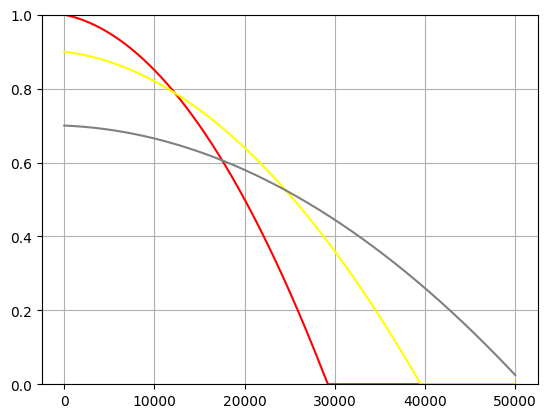

In [56]:
soft_compound = Compound(name="Soft", base_grip=1.0, initial_degradation_rate=0.0005, degradation_rate_change=0.00002)
medium_compound = Compound(name="Medium", base_grip=0.9, initial_degradation_rate=0.0003, degradation_rate_change=0.00001)
hard_compound = Compound(name="Hard", base_grip=0.7, initial_degradation_rate=0.0001, degradation_rate_change=0.000005)


soft_tire = Tire(soft_compound)
medium_tire = Tire(medium_compound)
hard_tire = Tire(hard_compound)

soft_grip = []
medium_grip = []
hard_grip = []

for i in range(50000):
    soft_grip.append(soft_tire.get_grip())
    medium_grip.append(medium_tire.get_grip())
    hard_grip.append(hard_tire.get_grip())
    soft_tire.apply_stress(1)
    medium_tire.apply_stress(1)
    hard_tire.apply_stress(1)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(soft_grip, color='red')
ax.plot(medium_grip, color='yellow')
ax.plot(hard_grip, color='gray')
ax.set_ylim([0, 1])
ax.grid()

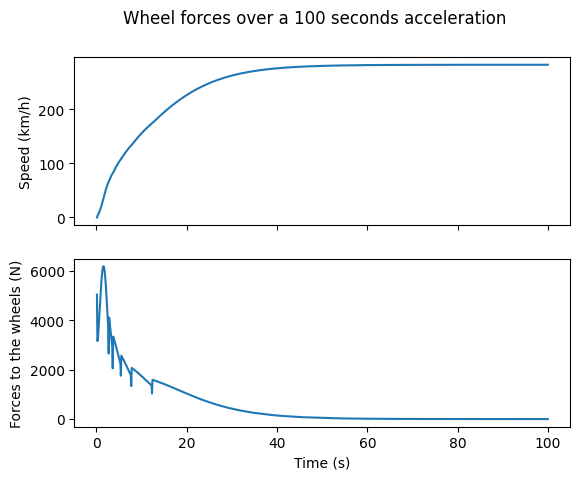

In [57]:
import numpy as np

car.reset()

ten_seconds = (np.arange(1000) + 1) / 10 # Time step every 0.1s up to 100 seconds

wheel_forces_values_1 = []
speed_values_1 = []

for i in ten_seconds:
    speed_values_1 = np.append(speed_values_1, ms_to_kph(car.speed))
    wheel_forces_values_1 = np.append(wheel_forces_values_1, car.force_wheel())
    car.accelerate(0.1) # Move the time 0.1s forward
    auto_transmission.update()

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

fig.suptitle('Wheel forces over a 100 seconds acceleration')

ax1.plot(ten_seconds, speed_values_1)
ax1.set_ylabel('Speed (km/h)')
ax2.plot(ten_seconds, wheel_forces_values_1)
ax2.set_ylabel('Forces to the wheels (N)')
ax2.set_xlabel('Time (s)')
fig.savefig('fig/wheel_forces.svg', format='svg')

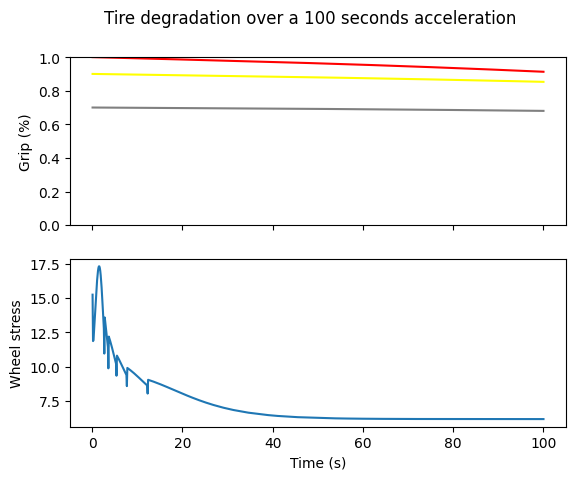

In [58]:
soft_tire.reset()
medium_tire.reset()
hard_tire.reset()

soft_grip = []
medium_grip = []
hard_grip = []
stress_evolution = []

for i, s in enumerate(ten_seconds):
    stress = calculate_stress(wheel_forces_values_1[i], 0, 9.81 * 700, 90, 0.8)
    stress_evolution.append(stress)
    soft_grip.append(soft_tire.get_grip())
    medium_grip.append(medium_tire.get_grip())
    hard_grip.append(hard_tire.get_grip())
    
    soft_tire.apply_stress(stress)
    medium_tire.apply_stress(stress)
    hard_tire.apply_stress(stress)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

fig.suptitle('Tire degradation over a 100 seconds acceleration')

ax1.plot(ten_seconds, soft_grip, color='red')
ax1.plot(ten_seconds, medium_grip, color='yellow')
ax1.plot(ten_seconds, hard_grip, color='gray')
ax1.set_ylim([0, 1])
ax1.set_ylabel('Grip (%)')
ax2.plot(ten_seconds, stress_evolution)
ax2.set_ylabel('Wheel stress')
ax2.set_xlabel('Time (s)')
fig.savefig('fig/wheel_stress.svg', format='svg')

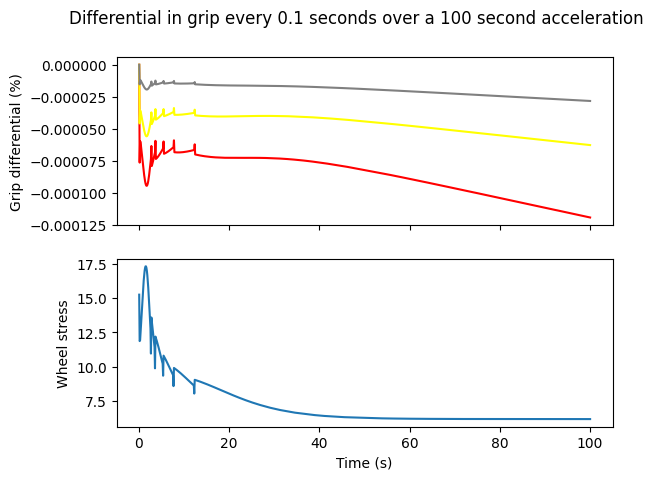

In [59]:
soft_tire.reset()
medium_tire.reset()
hard_tire.reset()

soft_grip = []
medium_grip = []
hard_grip = []
stress_evolution = []

soft_prev = soft_tire.get_grip()
medium_prev = medium_tire.get_grip()
hard_prev = hard_tire.get_grip()

for i, s in enumerate(ten_seconds):
    stress = calculate_stress(wheel_forces_values_1[i], 0, 9.81 * 700, 90, 0.8)
    stress_evolution.append(stress)

    soft_grip.append(soft_tire.get_grip() - soft_prev)
    medium_grip.append(medium_tire.get_grip() - medium_prev)
    hard_grip.append(hard_tire.get_grip() - hard_prev)
    
    soft_prev = soft_tire.get_grip()
    medium_prev = medium_tire.get_grip()
    hard_prev = hard_tire.get_grip()
    
    soft_tire.apply_stress(stress)
    medium_tire.apply_stress(stress)
    hard_tire.apply_stress(stress)


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

fig.suptitle('Differential in grip every 0.1 seconds over a 100 second acceleration')

ax1.plot(ten_seconds, soft_grip, color='red')
ax1.plot(ten_seconds, medium_grip, color='yellow')
ax1.plot(ten_seconds, hard_grip, color='gray')

ax1.set_ylabel('Grip differential (%)')
ax2.plot(ten_seconds, stress_evolution)
ax2.set_ylabel('Wheel stress')
ax2.set_xlabel('Time (s)')
fig.savefig('fig/wheel_stress_dif.svg', format='svg')